In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
#from xgboost import XGBRegressor
#from nltk import word_tokenize
#from nltk.corpus import stopwords
from keras.layers import (
    GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional,
    SpatialDropout1D, Dense, Activation, Dropout, BatchNormalization,
    Embedding, LSTM, GRU
)
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError, MeanSquaredError
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
# from keras.utils import np_utils

from scipy.stats import pearsonr
from string import punctuation
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
#import tensorflow_hub as tfh
from transformers import TFBertModel, BertTokenizer

# Comment out unused import
# stop_words = stopwords.words('english')

ModuleNotFoundError: No module named 'pandas'

In [3]:
import tensorflow as tf

In [6]:
import os
os.getcwd()

'c:\\Users\\logis\\Logis\\Study\\Self Edu\\Projects\\IELTS\\model'

In [8]:
model = tf.keras.models.load_model('bert_text_model.keras')

TypeError: 'str' object is not callable

In [3]:
df = pd.read_csv('ielts_writing_dataset.csv')

In [4]:
print(df.shape)
df.head(3)

(1435, 9)


,Task_Type,Question,Essay,Examiner_Commen,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall
0,1,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5
1,2,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5
2,1,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0


In [5]:
df = df.rename(columns={'Examiner_Commen': 'Comment'})

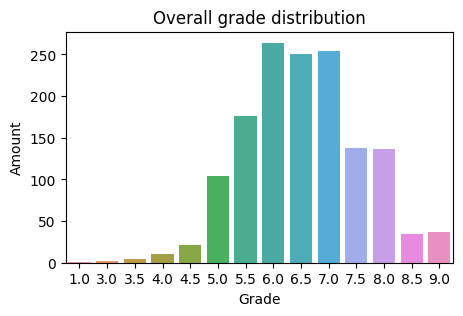

In [6]:
# Assuming 'column_name' is the name of the column you want to plot
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
sns.countplot(data=df, x='Overall')
plt.title(f'Overall grade distribution')
plt.xlabel('Grade')
plt.ylabel('Amount')
plt.show()


In [7]:
df = df[df['Overall'].map(df['Overall'].value_counts()) > 1]

<ipython-input-8-afc8180eb243>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))


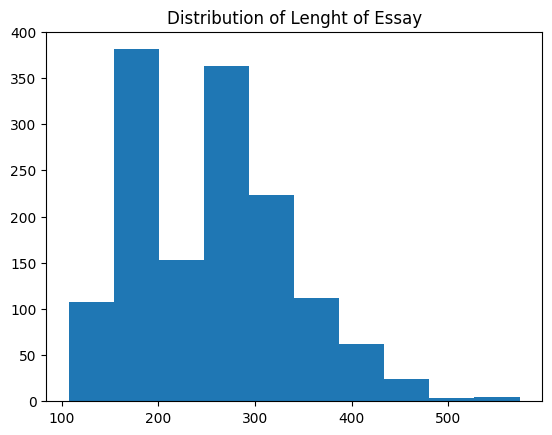

In [8]:
df["Length"]=df["Essay"].apply(lambda x: len(x.split(" ")))
plt.hist(df["Length"])
plt.title("Distribution of Lenght of Essay")
plt.show()

In [9]:
# Group by "Overall" and count non-None values in "Comment"
df[df['Comment'].notna()].groupby("Overall")["Comment"].count()

Overall
5.0     8
6.0    24
7.0    17
8.0    13
Name: Comment, dtype: int64

In [10]:
df['Has_Comment'] = df['Comment'].notna().astype(int)
df['Has_Comment']

0       0
1       0
2       0
3       0
4       0
       ..
1430    1
1431    1
1432    1
1433    1
1434    1
Name: Has_Comment, Length: 1434, dtype: int64

In [11]:
df.groupby(["Overall"]).agg({"Length":"mean"})

,Length
Overall,
3.0,192.500000
3.5,137.200000
4.0,211.636364
4.5,217.619048
5.0,231.509615
5.5,226.011364
6.0,246.022727
6.5,245.872000
7.0,258.110236


In [12]:
df['Question'].isna().sum()

0

In [13]:
df.describe()

,Task_Type,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall,Length,Has_Comment
count,1434.000000,0.0,0.0,0.0,0.0,1434.000000,1434.000000,1434.000000
mean,1.552999,NaN,NaN,NaN,NaN,6.554045,253.932357,0.043236
std,0.497357,NaN,NaN,NaN,NaN,1.048397,81.337255,0.203458
min,1.000000,NaN,NaN,NaN,NaN,3.000000,107.000000,0.000000
25%,1.000000,NaN,NaN,NaN,NaN,6.000000,179.000000,0.000000
50%,2.000000,NaN,NaN,NaN,NaN,6.500000,256.000000,0.000000
75%,2.000000,NaN,NaN,NaN,NaN,7.000000,304.000000,0.000000
max,2.000000,NaN,NaN,NaN,NaN,9.000000,574.000000,1.000000


In [14]:
# Transform the 'Category' column to 0s and 1s
df['Task_Type'] = (df['Task_Type'] == 2).astype(int)

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Task_Type'], prefix=['Task_Type'])

In [15]:
df.head(3)

,Question,Essay,Comment,Task_Response,Coherence_Cohesion,Lexical_Resource,Range_Accuracy,Overall,Length,Has_Comment,Task_Type_0,Task_Type_1
0,The bar chart below describes some changes abo...,"Between 1995 and 2010, a study was conducted r...",NaN,NaN,NaN,NaN,NaN,5.5,125,0,1,0
1,Rich countries often give money to poorer coun...,Poverty represents a worldwide crisis. It is t...,NaN,NaN,NaN,NaN,NaN,6.5,258,0,0,1
2,The bar chart below describes some changes abo...,The left chart shows the population change hap...,NaN,NaN,NaN,NaN,NaN,5.0,163,0,1,0


In [16]:
config ={
    "max_seq_length": 512,
    "bert_model_name": "bert-base-uncased",
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 50,
    "loss": 'mean_squared_error',
    "metrics": [MeanAbsoluteError(), RootMeanSquaredError()],
}

In [17]:
# Load pre-trained BERT model and tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(config['bert_model_name'])
bert_model = TFBertModel.from_pretrained(config['bert_model_name'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [18]:
X = df[['Essay',
        'Task_Type_0',
        'Task_Type_1',
        'Length']]

y = df['Overall']

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=42
)

In [20]:
text_colums_indexes = 0
numerical_columns_indexes = [1, 2, 3]

# Create a StandardScaler instance and fit/transform on X_train
scaler = StandardScaler()
numerical_features_train = scaler.fit_transform(X_train[:, numerical_columns_indexes])
numerical_features_val = scaler.transform(X_val[:, numerical_columns_indexes])

In [21]:
text_features_train = X_train[:, text_colums_indexes]
text_features_val = X_val[:, text_colums_indexes]

train_input_ids = bert_tokenizer(list(text_features_train), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']
val_input_ids = bert_tokenizer(list(text_features_val), padding=True, truncation=True, return_tensors='tf', max_length=config['max_seq_length'])['input_ids']

In [22]:
X_train = {
    "input_ids": train_input_ids,
    "numerical_features": numerical_features_train
}

X_val = {
    "input_ids": val_input_ids,
    "numerical_features": numerical_features_val
}

In [23]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32, name="input_ids")
numerical_features = tf.keras.layers.Input(shape=(3,), dtype=tf.float32, name="numerical_features")

# BERT embedding layer
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output

# Combine BERT output with numerical features
concatenated_features = tf.keras.layers.concatenate([pooler_output, numerical_features])

# Custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='linear')
])

# Connect regression head to combined features
regression_output = regression_head(concatenated_features)

# Create the final model
bert_with_num_model = tf.keras.models.Model(inputs=[input_ids, numerical_features], outputs=regression_output)

In [24]:
# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model
bert_with_num_model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
              loss=config['loss'],
              metrics=config['metrics'])

# Print model summary
bert_with_num_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]']           
 )                           ngAndCrossAttentions(last_   40                                      
                             hidden_state=(None, 512, 7                                           
                             68),                                                                 
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                       

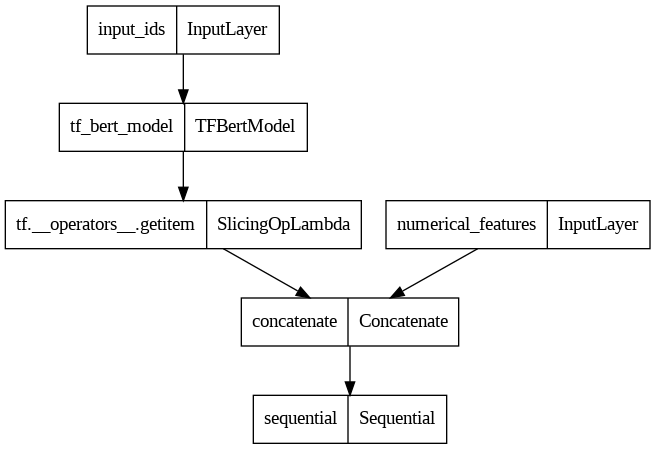

In [25]:
tf.keras.utils.plot_model(bert_with_num_model)

In [32]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bert_with_num.h5',  # Specify the path to save the best model
    monitor='val_mean_absolute_error',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=0                 # Verbosity mode (0 for silent)
)

# Define a callback to perform early stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_absolute_error',  # Monitor validation loss
    min_delta=0,         # Minimum change in validation loss to be considered an improvement
    patience=3,          # Number of epochs with no improvement after which training will stop
    verbose=0,           # Verbosity mode (0 for silent)
    mode='auto'          # Automatically infer the direction of loss improvement
)

In [27]:
history_bert_with_num = bert_with_num_model.fit(X_train, y_train,
    epochs=config['epochs'],
    batch_size=config['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 5.9566 - mean_absolute_error: 1.8898 - root_mean_squared_error: 2.4406

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 92s 2s/step - loss: 5.9566 - mean_absolute_error: 1.8898 - root_mean_squared_error: 2.4406 - val_loss: 1.1383 - val_mean_absolute_error: 0.8527 - val_root_mean_squared_error: 1.0669
Epoch 2/50
36/36 [==============================] - 76s 2s/step - loss: 2.2132 - mean_absolute_error: 1.1854 - root_mean_squared_error: 1.4877 - val_loss: 0.8638 - val_mean_absolute_error: 0.7416 - val_root_mean_squared_error: 0.9294
Epoch 3/50
36/36 [==============================] - 76s 2s/step - loss: 2.1146 - mean_absolute_error: 1.1636 - root_mean_squared_error: 1.4542 - val_loss: 1.0044 - val_mean_absolute_error: 0.8060 - val_root_mean_squared_error: 1.0022
Epoch 4/50
36/36 [==============================] - 80s 2s/step - loss: 1.8505 - mean_absolute_error: 1.0810 - root_mean_squared_error: 1.3603 - val_loss: 0.7781 - val_mean_absolute_error: 0.7042 - val_root_mean_squared_error: 0.8821
Epoch 5/50
36/36 [==============================] - 86s 2s/step - loss: 1.7

In [28]:
predictions_bert_with_num = bert_with_num_model.predict(X_val)
print(mean_absolute_error(y_val, predictions_bert_with_num))

9/9 [==============================] - 15s 1s/step
0.7386234878247623


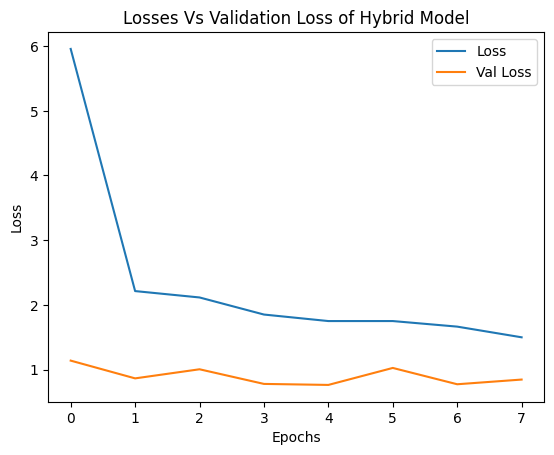

In [29]:
plt.plot(history_bert_with_num.history["loss"])
plt.plot(history_bert_with_num.history["val_loss"])
plt.title("Losses Vs Validation Loss of Hybrid Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [31]:
# Define a dictionary to map custom layer names to their classes
custom_objects = {'TFBertModel': TFBertModel}

# Replace 'path_to_your_model.h5' with the path to your model file.
model_path = 'bert_with_num.h5'

# Load the Keras model with custom object mapping
with tf.keras.utils.custom_object_scope(custom_objects):
    loaded_model = tf.keras.models.load_model(model_path)


predictions_bert_with_num = loaded_model.predict(X_val)
print(mean_absolute_error(y_val, predictions_bert_with_num))

9/9 [==============================] - 16s 1s/step
0.6944802297532351


In [33]:
# Create a custom regression head
regression_head = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')
])

# Combine BERT and Regression Head
input_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), dtype=tf.int32)
bert_output = bert_model(input_ids)[0]  # BERT's output
pooler_output = bert_output[:, 0, :]     # Pooler output
regression_output = regression_head(pooler_output)  # Custom regression head

model = tf.keras.models.Model(inputs=input_ids, outputs=regression_output)

In [34]:
# Set BERT layers as non-trainable
for layer in bert_model.layers:
    layer.trainable = False

# Compile the model, specifying the loss and metrics
model.compile(optimizer=tf.keras.optimizers.Adam(config['learning_rate']),
                        loss=config['loss'],
                        metrics=config['metrics'])

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512)]             0         
                                                                 
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPo   109482240 
 )                           olingAndCrossAttentions             
                             (last_hidden_state=(Non             
                             e, 512, 768),                       
                              pooler_output=(None, 7             
                             68),                                
                              past_key_values=None,              
                             hidden_states=None, att             
                             entions=None, cross_att             
                             entions=None)                       
                                                           

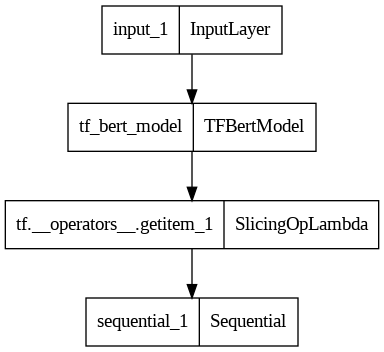

In [35]:
tf.keras.utils.plot_model(model)

In [36]:
# Define a callback to save the model with the lowest validation loss
checkpoint_callback_text = tf.keras.callbacks.ModelCheckpoint(
    filepath='bert_text.h5',  # Specify the path to save the best model
    monitor='val_mean_absolute_error',       # Monitor validation loss
    save_best_only=True,      # Save only the best model (lowest val_loss)
    mode='min',               # Consider lower values as better
    verbose=0                 # Verbosity mode (0 for silent)
)

In [ ]:
history_bert_text = model.fit(X_train['input_ids'], y=y_train,
                                    epochs=config['epochs'],
                                    batch_size=config['batch_size'],
                                    validation_data=(X_val['input_ids'], y_val),
                                    callbacks=[checkpoint_callback, earlystop_callback])

Epoch 1/50
36/36 [==============================] - ETA: 0s - loss: 9.6944 - mean_absolute_error: 2.1256 - root_mean_squared_error: 2.8148

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 89s 2s/step - loss: 9.6944 - mean_absolute_error: 2.1256 - root_mean_squared_error: 2.8148 - val_loss: 2.0316 - val_mean_absolute_error: 1.1958 - val_root_mean_squared_error: 1.4254
Epoch 2/50
36/36 [==============================] - 77s 2s/step - loss: 4.3987 - mean_absolute_error: 1.6971 - root_mean_squared_error: 2.0973 - val_loss: 0.9019 - val_mean_absolute_error: 0.7558 - val_root_mean_squared_error: 0.9497
Epoch 3/50
28/36 [======================>.......] - ETA: 12s - loss: 3.2828 - mean_absolute_error: 1.4564 - root_mean_squared_error: 1.8118

In [ ]:
predictions_bert = model.predict(X_val['input_ids'])
print(mean_absolute_error(y_val, predictions_bert))

9/9 [==============================] - 14s 1s/step
0.7683084584279343


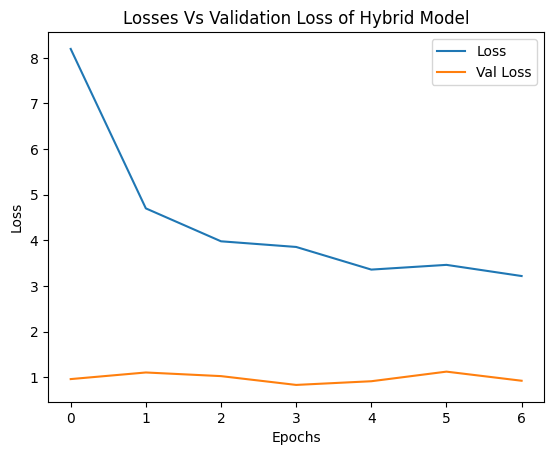

In [ ]:
plt.plot(history_bert_text.history["loss"])
plt.plot(history_bert_text.history["val_loss"])
plt.title("Losses Vs Validation Loss of Hybrid Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss","Val Loss"])

In [ ]:
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(X_train)+list(X_val))
X_train_tfv = tfv.transform(X_train)
X_val_tfv = tfv.transform(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


In [ ]:
lr = LinearRegression()
lr.fit(X_train_tfv, y_train)
predictions = lr.predict(X_val_tfv)

print("MAE:", mean_absolute_error(y_val, predictions))

MAE: 0.5920672752908288


In [ ]:
predictions_BERT = predictions_BERT.squeeze()

In [ ]:
pred = (predictions + predictions_BERT)/2

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val, pred)
mae

0.668092619777633

In [ ]:
for i in range(20):
    print(round(predictions[i], 2), y_val.iloc[i])

In [ ]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

ctv.fit(list(X_train)+list(X_val))
X_train_ctv = ctv.transform(X_train)
X_val_ctv = ctv.transform(X_val)

In [ ]:
lr = LinearRegression()
lr.fit(X_train_ctv, y_train)
predictions = lr.predict(X_val_ctv)

print("MAE:", mean_absolute_error(y_val, predictions))

In [ ]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train_tfv, y_train)
predictions = xgb.predict(X_val_tfv)

print("MAE:", mean_absolute_error(y_val, predictions))

In [ ]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train_ctv, y_train)
predictions = xgb.predict(X_val_ctv)

print("MAE:", mean_absolute_error(y_val, predictions))

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('../input/glove-embeddings/glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        pass
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

In [ ]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [ ]:
# create sentence vectors using the above function for training and validation set
X_train_glove = [sent2vec(x) for x in tqdm(X_train)]
X_val_glove = [sent2vec(x) for x in tqdm(X_val)]

In [ ]:
xgb = XGBRegressor(max_depth=7, n_estimators=200, colsample_bytree=0.8,
                        subsample=0.8, nthread=10, learning_rate=0.1)
xgb.fit(X_train_glove, y_train)
predictions = xgb.predict(X_val_glove)

print("MAE:", mean_absolute_error(y_val, predictions))

In [ ]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
X_train_glove_scl = scl.fit_transform(X_train_glove)
X_val_glove_scl = scl.transform(X_val_glove)

In [ ]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(1))

# compile the model
model.compile(loss='MAE', optimizer='adam')

In [ ]:
model.fit(X_train_glove_scl, y=y_train, batch_size=64,
          epochs=50, verbose=1,
          validation_data=(X_val_glove_scl, y_val))

In [ ]:
# using keras tokenizer here
token = text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(X_train) + list(X_val))
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

# zero pad the sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

word_index = token.word_index

In [ ]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# A simple LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

In [ ]:
model.fit(X_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(X_val_pad, y_val), callbacks=[earlystop])

In [ ]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1))
model.compile(loss='mse', metrics='mae', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(X_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(X_val_pad, y_val), callbacks=[earlystop])

In [ ]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))


model.add(Dense(1024, activation='relu'))

model.add(Dense(1))
model.compile(loss='mse', metrics='mae', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(X_train_pad, y=y_train, batch_size=512, epochs=100, verbose=1, validation_data=(X_val_pad, y_val), callbacks=[earlystop])